# Boosting for regression trees

### Algorithm
1. Set $\hat{f}=0$ and $r_{i} = y_{i}$ for all $i$ in the training set.
2. For $b = 1,2,..,B,$ repeat:
    - Fir a tree $\hat{f}^{b}$ with d splits (d +1 terminal nodes) to the training data $(X, r)$.
    - Update $\hat{f} \leftarrow \hat{f} + \lambda \hat{f}^{b}$, where $\lambda$ is the learning rate.
    - Update the residuals $r_{i} \leftarrow r_{i} - \lambda \hat{f}^{b}(X_{i})$ for all $i$ in the training set.

3. Output the boosted model $\hat{f} = \sum_{b=1}^{B} \lambda \hat{f}^{b}(x)$.

In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Load data

In [2]:
import kagglehub
path = kagglehub.dataset_download("floser/hitters")
df = pd.read_csv(path +'\\Hitters.csv')
df.head()

C:\Users\Piotr Matusiewicz\Codebase-projects\AIbox\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [3]:
df = pd.get_dummies(df)
df = df.dropna(subset=['Salary'])
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,False,True,False,True,False,True
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,True,False,False,True,True,False
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,False,True,True,False,False,True
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,False,True,True,False,False,True
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750.0,True,False,False,True,True,False


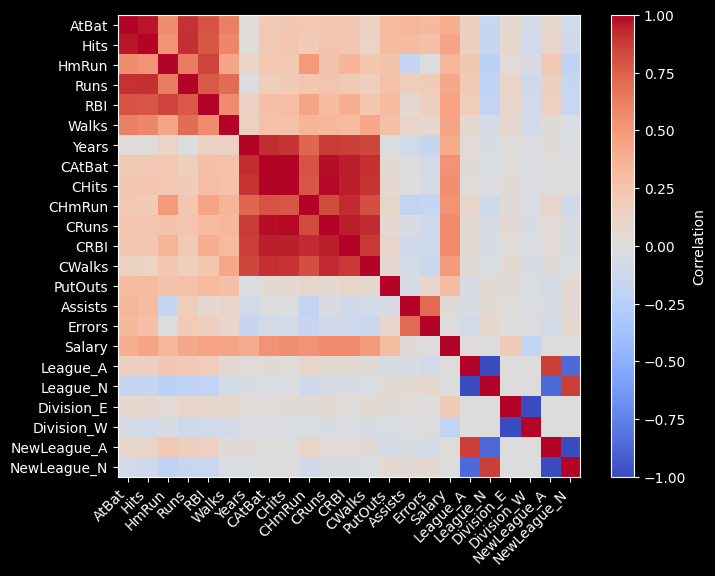

In [4]:
corr = df.corr().values
features = df.columns

plt.figure(figsize=(8, 6))
plt.imshow(corr, interpolation='nearest', cmap='coolwarm')
plt.colorbar(label='Correlation')
plt.xticks(np.arange(len(features)), features, rotation=45, ha='right')
plt.yticks(np.arange(len(features)), features)

plt.show()

In [5]:
df['Salary'] = np.log(df['Salary'])
X = df.drop(['Salary'], axis=1)
y = df['Salary']

X_train = X.iloc[:200,:]
y_train = y.iloc[:200]
X_test = X.iloc[200:,:]
y_test = y.iloc[200:]


In [6]:
shrinkage_values = [.001, .025, .005, .01, .025, .05, .1, .25, .5]
mses = []
for i in shrinkage_values:
    bst = GradientBoostingRegressor(learning_rate=i, n_estimators=1000, random_state=1)
    bst.fit(X_train, y_train)
    mses.append(mean_squared_error(y_train, bst.predict(X_train)))

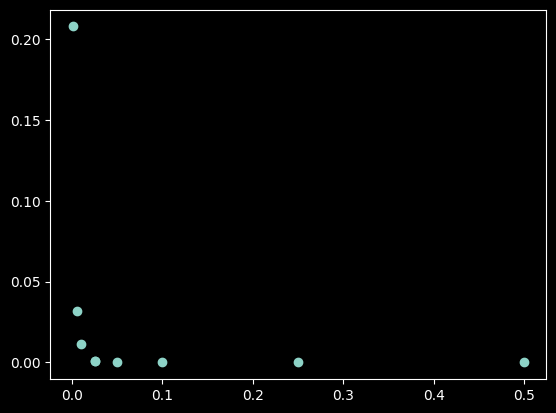

In [7]:
plt.scatter(shrinkage_values, mses)

In [8]:
# Boosting with different shrinkage values
shrinkage_values = [.001, .025, .005, .01, .025, .05, .1, .25, .5]
mses = []
for i in shrinkage_values:
    bst = GradientBoostingRegressor(learning_rate=i, n_estimators=1000, random_state=1)
    bst.fit(X_train, y_train)
    mses.append(mean_squared_error(y_test, bst.predict(X_test)))

0.20875

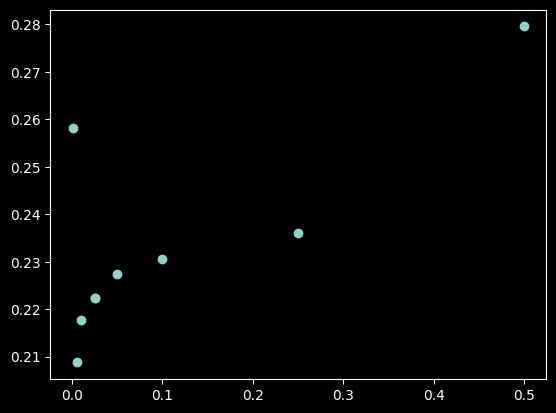

In [9]:
plt.scatter(shrinkage_values, mses)
round(float(np.min(mses)),5)

### Comparing to Linear Regression and Lasso Cross-Validation

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
rgr = LinearRegression()
rgr.fit(X_train, y_train)

print('MSE:', mean_squared_error(y_test, rgr.predict(X_test)))

MSE: 0.49179593754549156


In [11]:
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)

print('MSE:', mean_squared_error(y_test, lasso.predict(X_test)))

MSE: 0.4865863696030244


### Features importance

Text(0.5, 0, 'Variable importance')

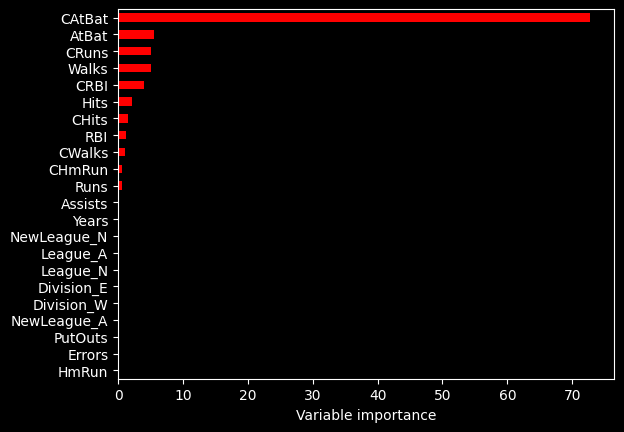

In [12]:
bst = GradientBoostingRegressor(learning_rate=0.005)  # 0.005 is the learning_rate corresponding to the best test MSE
bst.fit(X_train, y_train)

feature_importance = bst.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X.columns).sort_values(inplace=False)
rel_imp.T.plot(kind='barh', color='r')
plt.xlabel('Variable importance')

### Applying bagging to boosting

In [13]:
from sklearn.ensemble import BaggingRegressor
bagging = BaggingRegressor()
bagging.fit(X_train, y_train)
print('MSE:', mean_squared_error(y_test, bagging.predict(X_test)))

MSE: 0.20679381592713625


RFE,box plot, Friedman statistical tests, Variance inflation factor (VIF)

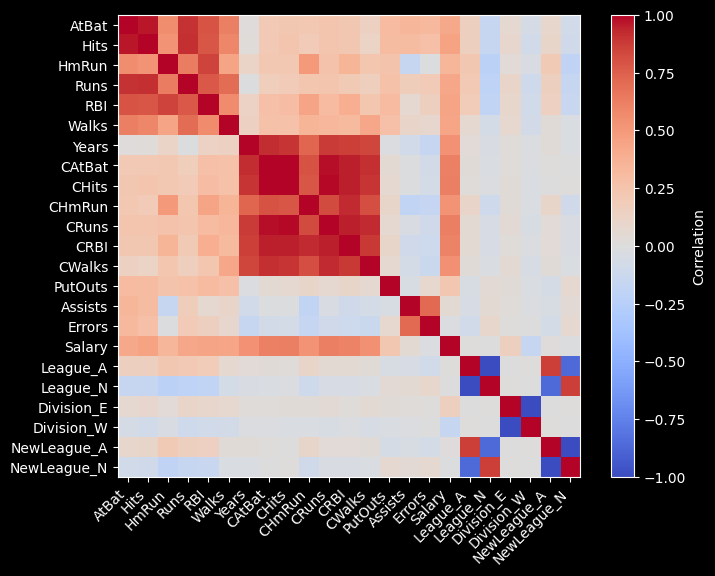

In [16]:
corr = df.corr().values
features = df.columns

plt.figure(figsize=(8, 6))
plt.imshow(corr, interpolation='nearest', cmap='coolwarm')
plt.colorbar(label='Correlation')
plt.xticks(np.arange(len(features)), features, rotation=45, ha='right')
plt.yticks(np.arange(len(features)), features)
print()

In [17]:
df.drop(columns=["CHits", "CRuns", "CRBI", "CWalks"], inplace=True)

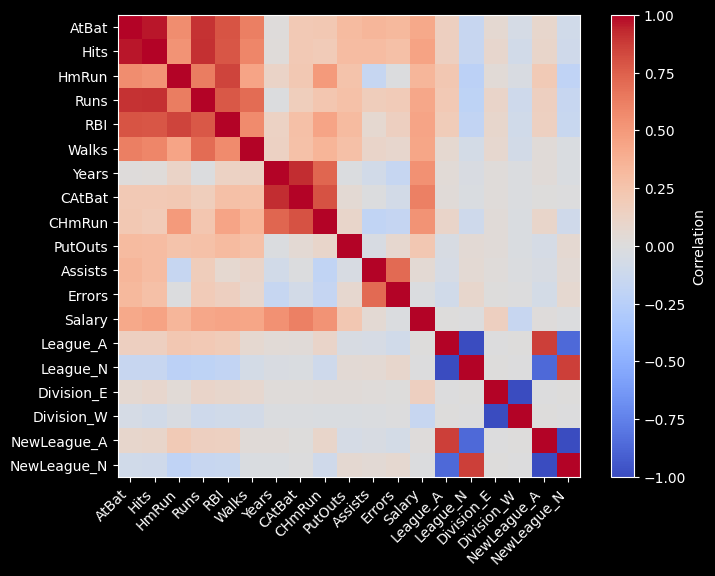

In [18]:
corr = df.corr().values
features = df.columns

plt.figure(figsize=(8, 6))
plt.imshow(corr, interpolation='nearest', cmap='coolwarm')
plt.colorbar(label='Correlation')
plt.xticks(np.arange(len(features)), features, rotation=45, ha='right')
plt.yticks(np.arange(len(features)), features)
print()


In [39]:
df.drop(columns=[''], inplace=True)

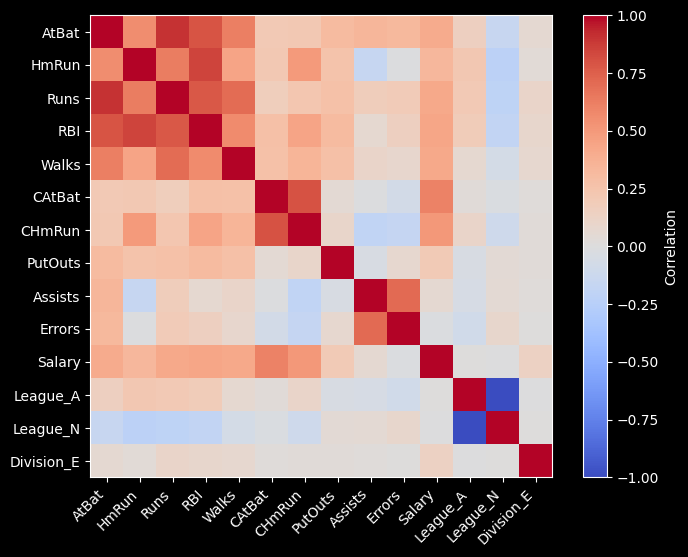

In [41]:
corr = df.corr().values
features = df.columns

plt.figure(figsize=(8, 6))
plt.imshow(corr, interpolation='nearest', cmap='coolwarm')
plt.colorbar(label='Correlation')
plt.xticks(np.arange(len(features)), features, rotation=45, ha='right')
plt.yticks(np.arange(len(features)), features)
print()


In [42]:
df['Salary'] = np.log(df['Salary'])
X = df.drop(['Salary'], axis=1)
y = df['Salary']

X_train = X.iloc[:200,:]
y_train = y.iloc[:200]
X_test = X.iloc[200:,:]
y_test = y.iloc[200:]


In [43]:
# Boosting with different shrinkage values
shrinkage_values = [.001, .025, .005, .01, .025, .05, .1, .25, .5]
mses = []
for i in shrinkage_values:
    bst = GradientBoostingRegressor(learning_rate=i, n_estimators=1000, random_state=1)
    bst.fit(X_train, y_train)
    mses.append(mean_squared_error(y_test, bst.predict(X_test)))

0.00855

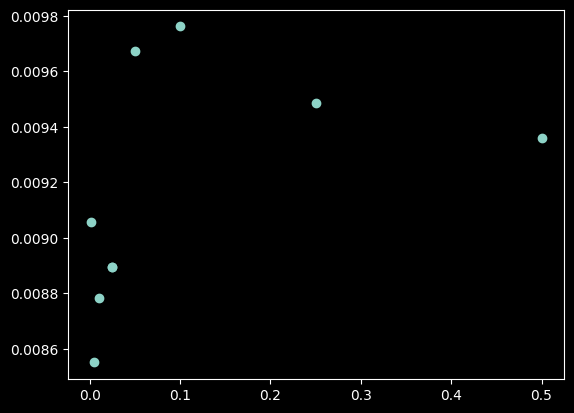

In [44]:
plt.scatter(shrinkage_values, mses)
round(float(np.min(mses)),5)

In [45]:
linMod = LinearRegression()
linMod.fit(X_train, y_train)
y_pred = linMod.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

MSE: 0.0168598253086589


In [28]:
df.head()


,AtBat,HmRun,Runs,RBI,Walks,CAtBat,CHmRun,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,7,24,38,39,3449,69,632,43,10,1.818615,False,True,False,True,False,True
2,479,18,66,72,76,1624,63,880,82,14,1.820312,True,False,False,True,True,False
3,496,20,65,78,37,5628,225,200,11,3,1.826903,False,True,True,False,False,True
4,321,10,39,42,30,396,12,805,40,4,1.507702,False,True,True,False,False,True
5,594,4,74,51,35,4408,19,282,421,25,1.890106,True,False,False,True,True,False


In [31]:
A = df[df['NewLeague_A']==False]['Salary']
B = df[df['NewLeague_A']==True]['Salary']
from scipy.stats import mannwhitneyu
mannwhitneyu(A, B)

MannwhitneyuResult(statistic=np.float64(8561.0), pvalue=np.float64(0.9488000565657139))